# Confronto tra DGF-PT1 + DGF-PT2 e DGF-PTTOT
Di seguito, confrontiamo le previsioni fatte con il modello DGF-PTTOT e le previsioni fatte con la combinazione delle previsioni dei modelli DGF-PT1 e DGF-PT2. Nel secondo caso, la previsione complessiva è data dalla somma della previsione di DGF-PT1 e della previsione di DGF-PT2, quest'ultima moltiplicata per il numero di ore di previsione meno uno.


Si ricorda che il dataset usato per DGF-PTTOT è stato generato prendendo quello originale e calcolando, per N da 1 a 140:

    time_tot = time1 + time2 * (N-1)
    
Quindi, se nel primo approccio (DGF-PT1 + DGF-PT2) si effettua la combinazione delle due previsioni usando la medesima formula, nel secondo approccio (DGF-PTTOT) il modello prevede la combinazione delle due osservazioni.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cosmo_dlp.model import CosmoData, CosmoPredictor
import pickle
import io
import yaml
import seaborn as sns
import numpy as np
import os.path
sns.set_theme(style="whitegrid")

train_tot_df = pd.read_csv("data/input/DGF_PTTOT_train.csv")
test_tot_df = pd.read_csv("data/input/DGF_PTTOT_test.csv")

In [2]:
test_res_tot_file = "data/output/DGF_PTTOT_test_result.csv"

if os.path.exists(test_res_tot_file):
    print("Carico i risultati del modello da file")
else:
    with open("data/hpopt/DGF_PTTOT.pk", "rb") as fp:
        trials = pickle.load(fp)
        best = trials.best_trial
        
    config = best["result"]["config"]
    cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
    best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
    
    data = CosmoData(train_tot_df, None, test_tot_df, config["batch"])
    model = CosmoPredictor(data.input_size, config)
    train_res_tot = model.fit(data, best_epoch)
    test_res_tot = model.test(data)
    test_res_tot.to_csv(test_res_tot_file, index=False)
    
test_res_tot = pd.read_csv(test_res_tot_file)

Carico i risultati del modello da file


In [3]:
train_t1_df = pd.read_csv("data/input/DGF_PT1_train.csv")
train_t2_df = pd.read_csv("data/input/DGF_PT2_train.csv")
test_t1t2_df = test_tot_df.drop("n_hours", axis=1)
test_res_t1t2_file = "data/output/DGF_PT1PT2_test_result.csv"

if os.path.exists(test_res_t1t2_file):
    print("Carico i risultati del modello da file")
else:
    with open("data/hpopt/DGF_PT1.pk", "rb") as fp:
        trials = pickle.load(fp)
        best = trials.best_trial
        
    config = best["result"]["config"]
    cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
    best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
    
    data = CosmoData(train_t1_df, None, test_t1t2_df, config["batch"])
    model = CosmoPredictor(data.input_size, config)
    train_res_t1 = model.fit(data, best_epoch)
    test_res_t1 = model.test(data)
    
    with open("data/hpopt/DGF_PT2.pk", "rb") as fp:
        trials = pickle.load(fp)
        best = trials.best_trial
        
    config = best["result"]["config"]
    cv_res = pd.read_csv(io.StringIO(best["result"]["csv"]))
    best_epoch = cv_res.groupby("epoch").val_loss.mean().idxmin()
    
    data = CosmoData(train_t2_df, None, test_t1t2_df, config["batch"])
    model = CosmoPredictor(data.input_size, config)
    train_res_t2 = model.fit(data, best_epoch)
    test_res_t2 = model.test(data)
    
    test_res_t1t2 = pd.DataFrame()
    test_res_t1t2["target"] = test_tot_df["time_tot"]
    test_res_t1t2["prediction"] = test_res_t1["prediction"] + test_res_t2["prediction"] * (test_tot_df["n_hours"] - 1)
    test_res_t1t2.to_csv(test_res_t1t2_file, index=False)
    
test_res_t1t2 = pd.read_csv(test_res_t1t2_file)

Carico i risultati del modello da file


Le prestazioni, ad una prima analisi, sembrano essere molto simili:

In [4]:
test_res_tot["abs_err"] = (test_res_tot.target - test_res_tot.prediction).abs()
test_res_tot["rel_err"] = test_res_tot.abs_err / test_res_tot.target
test_res_tot["residual"] = test_res_tot.target - test_res_tot.prediction
test_res_tot[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,160073.000000,1.600730e+05
mean,33.747999,2.875299e-02
std,121.375019,4.941044e-02
min,0.000076,4.512699e-07
25%,2.755844,7.981233e-03
50%,9.364975,1.740951e-02
75%,30.666260,3.247521e-02
max,6354.672852,7.881131e-01


In [5]:
test_res_t1t2["abs_err"] = (test_res_t1t2.target - test_res_t1t2.prediction).abs()
test_res_t1t2["rel_err"] = test_res_t1t2.abs_err / test_res_t1t2.target
test_res_t1t2["residual"] = test_res_t1t2.target - test_res_t1t2.prediction
test_res_t1t2[["abs_err", "rel_err"]].describe()

,abs_err,rel_err
count,160073.000000,1.600730e+05
mean,34.966956,2.653445e-02
std,122.731122,3.834213e-02
min,0.000009,5.898027e-07
25%,2.709404,8.743827e-03
50%,9.874328,1.803148e-02
75%,33.602354,3.206633e-02
max,6515.668508,7.397577e-01


Anche MAE, RMSE e MAPE confermano l'impressione

In [6]:
for name, df in zip(("DGF-PTTOT", "DGF-PT1PT2"), (test_res_tot, test_res_t1t2)):
    print(f"MAE {name}:", df.abs_err.mean())

MAE DGF-PTTOT: 33.74799880056103
MAE DGF-PT1PT2: 34.966956142628284


In [7]:
for name, df in zip(("DGF-PTTOT", "DGF-PT1PT2"), (test_res_tot, test_res_t1t2)):
    print(f"RMSE {name}:", np.sqrt((df.abs_err ** 2).mean()))

RMSE DGF-PTTOT: 125.97908768537681
RMSE DGF-PT1PT2: 127.61474151812234


In [8]:
for name, df in zip(("DGF-PTTOT", "DGF-PT1PT2"), (test_res_tot, test_res_t1t2)):
    print(f"MAPE {name}:", 100 * df.rel_err.mean())

MAPE DGF-PTTOT: 2.8752986290800604
MAPE DGF-PT1PT2: 2.653445416344062


Di seguito, vediamo come CDF e PDF di errore assoluto e relativo confermino ulteriormente la sostanziale somiglianza tra i due modelli.

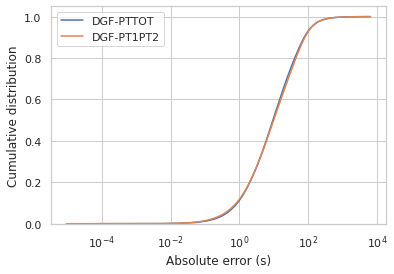

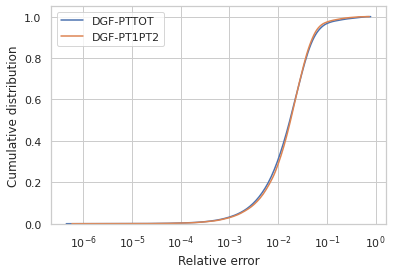

In [9]:
for name, df in zip(("DGF-PTTOT", "DGF-PT1PT2"), (test_res_tot, test_res_t1t2)):
    sns.kdeplot(data=df.query("abs_err > 0"), x="abs_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgf-pttot-pt1pt2/cdf-errore-assoluto.pdf")
plt.show()

for name, df in zip(("DGF-PTTOT", "DGF-PT1PT2"), (test_res_tot, test_res_t1t2)):
    sns.kdeplot(data=df.query("rel_err > 0"), x="rel_err", log_scale=True, cumulative=True, cut=0, label=name)
    
plt.legend()
plt.xlabel("Relative error")
plt.ylabel("Cumulative distribution")
plt.savefig("tex/images/dgf-pttot-pt1pt2/cdf-errore-relativo.pdf")
plt.show()

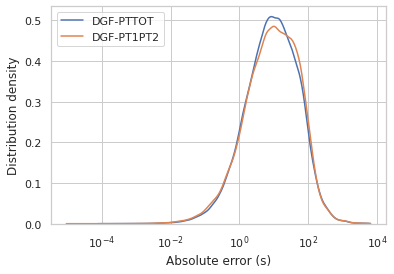

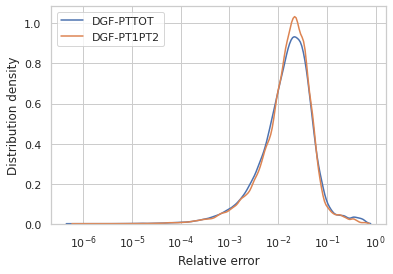

In [10]:
for name, df in zip(("DGF-PTTOT", "DGF-PT1PT2"), (test_res_tot, test_res_t1t2)):
    sns.kdeplot(data=df.query("abs_err > 0"), x="abs_err", log_scale=True, cumulative=False, cut=0, label=name)
    
plt.legend()
plt.xlabel("Absolute error (s)")
plt.ylabel("Distribution density")
plt.savefig("tex/images/dgf-pttot-pt1pt2/pdf-errore-assoluto.pdf")
plt.show()

for name, df in zip(("DGF-PTTOT", "DGF-PT1PT2"), (test_res_tot, test_res_t1t2)):
    sns.kdeplot(data=df.query("abs_err > 0"), x="rel_err", log_scale=True, cumulative=False, cut=0, label=name)
    
plt.xlabel("Relative error")
plt.ylabel("Distribution density")
plt.legend()
plt.savefig("tex/images/dgf-pttot-pt1pt2/pdf-errore-relativo.pdf")
plt.show()

## Conclusioni
I due approcci hanno prestazioni sostanzialmente uguali e quindi potrebbe non essere necessario usare un modello che consideri anche il numero di ore di previsione, il quale richiede un maggior numero di dati e quindi risorse computazionali. Probabilmente, l'analisi è lievemente falsata dal fatto che il dataset DGF-PTTOT è stato generato sinteticamente. Tuttavia, non essendo il tempo di esecuzione di ogni ora di previsione dipendente dal numero di ore calcolate ed essendo il modelli DGF-PT1 e DGF-PT2 sufficientemente precisi, si può supporre che, anche utilizzando dati reali, si avrebbero precisioni analoghe.